In [14]:
from osgeo import gdal
gdal.DontUseExceptions()

import numpy as np
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/ccollado/1_simulate_data')
from phisat_2.utils import tiff2array, plot_array_bands, get_corner_coordinates, get_centroid_coordinates, rgb_bands, src_band, stats_array, get_band_names


In [2]:
with gdal.Open('/home/ccollado/phileo_phisat2/draft/denmark-1_1.tif') as src:
    array = src_band(src, 'all')
    try:
        bands = src_band(src, 'bands')
        labels = src_band(src, 'labels')
    except:
        pass
    metadata = src.GetMetadata()
    band_names = src_band(src, 'bands_names')

In [13]:
with gdal.Open('buildings.tif') as src:
    array = src_band(src, 'all')
    band_names = src_band(src, 'bands_names')

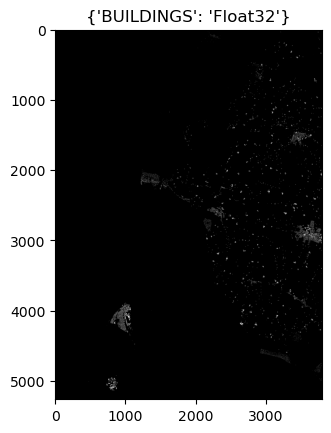

In [14]:
plt.imshow(array[0], cmap='gray')
plt.title(band_names)
plt.show()

In [5]:
from osgeo import gdal
import numpy as np

# Open the original TIFF file
input_file = '/home/ccollado/phileo_phisat2/draft/denmark-1_1.tif'
dataset = gdal.Open(input_file)

# Retrieve geospatial information
geotransform = dataset.GetGeoTransform()
projection = dataset.GetProjection()

# Extract metadata from the original dataset
metadata = dataset.GetMetadata()

In [6]:
# Initialize dictionaries to store band data
phisat2_bands = {}
world_cover = None
cloud_prob = None
buildings = None
roads = None

# Iterate over each band in the dataset
for i in range(1, dataset.RasterCount + 1):
    band = dataset.GetRasterBand(i)
    band_name = band.GetDescription()
    data = band.ReadAsArray()
    
    if band_name.startswith('PHISAT2'):
        data_uint16 = (data * 10000).astype(np.uint16)
        phisat2_bands[band_name] = data_uint16
    elif band_name == 'WORLD_COVER':
        data_uint8 = data.astype(np.uint8)
        world_cover = data_uint8
    elif band_name == 'CLOUD_PROB':
        # Scale probabilities to 0-255 and convert to uint8
        cloud_prob = (data * 255).astype(np.uint8)
    elif band_name == 'BUILDINGS':
        buildings = data
    elif band_name == 'ROADS':
        roads = data


In [7]:
def save_tif(filename, data_arrays, band_names, data_type, geotransform, projection, metadata=None):
    driver = gdal.GetDriverByName('GTiff')
    options = ['COMPRESS=LZW']  # Use LZW compression

    out_ds = driver.Create(
        filename,
        dataset.RasterXSize,
        dataset.RasterYSize,
        len(data_arrays),
        data_type,
        options
    )

    out_ds.SetGeoTransform(geotransform)
    out_ds.SetProjection(projection)
    
    # Set metadata if provided
    if metadata:
        out_ds.SetMetadata(metadata)

    for idx, array in enumerate(data_arrays):
        out_band = out_ds.GetRasterBand(idx + 1)
        out_band.WriteArray(array)
        out_band.SetDescription(band_names[idx])

    out_ds.FlushCache()
    out_ds = None  # Close the dataset


In [8]:
# Save PHISAT2 Bands with metadata
phisat2_band_names = list(phisat2_bands.keys())
phisat2_arrays = [phisat2_bands[name] for name in phisat2_band_names]

save_tif(
    filename='phisat2_bands.tif',
    data_arrays=phisat2_arrays,
    band_names=phisat2_band_names,
    data_type=gdal.GDT_UInt16,
    geotransform=geotransform,
    projection=projection,
    metadata=metadata  # Include metadata
)


In [9]:
if world_cover is not None:
    save_tif(
        filename='world_cover.tif',
        data_arrays=[world_cover],
        band_names=['WORLD_COVER'],
        data_type=gdal.GDT_Byte,
        geotransform=geotransform,
        projection=projection
    )


In [10]:
if cloud_prob is not None:
    save_tif(
        filename='cloud_prob.tif',
        data_arrays=[cloud_prob],
        band_names=['CLOUD_PROB'],
        data_type=gdal.GDT_Byte,  # Updated data type to Byte
        geotransform=geotransform,
        projection=projection
    )


In [11]:
if buildings is not None:
    save_tif(
        filename='buildings.tif',
        data_arrays=[buildings],
        band_names=['BUILDINGS'],
        data_type=gdal.GDT_Float32,
        geotransform=geotransform,
        projection=projection
    )


In [12]:
if roads is not None:
    save_tif(
        filename='roads.tif',
        data_arrays=[roads],
        band_names=['ROADS'],
        data_type=gdal.GDT_Float32,
        geotransform=geotransform,
        projection=projection
    )


In [32]:
input_folder = '/home/ccollado/phileo_phisat2/tiff_files'
input_files = os.listdir(input_folder)
input_file = input_files[0]

In [33]:
output_folder = '/home/ccollado/phileo_phisat2/converted_tiff_files'


# Check Converted Patches

In [38]:
building_array = np.load('/home/ccollado/phileo_phisat2/np_patches_128_converted/denmark-1_1_train_label_building.npy')
building_array.dtype

dtype('float32')

In [39]:
lc_array = np.load('/home/ccollado/phileo_phisat2/np_patches_128_converted/denmark-1_1_train_label_lc.npy')
lc_array.dtype

dtype('uint8')

In [41]:
phi2_array = np.load('/home/ccollado/phileo_phisat2/np_patches_128_converted/denmark-1_1_train_s2.npy')
phi2_array.dtype

dtype('uint16')

# Check If Metadata is There

In [42]:
with gdal.Open('/home/ccollado/phileo_phisat2/converted_tiff_files/denmark-1_1_phi2.tif') as src:
    metadata = src.GetMetadata() 

In [43]:
metadata

{'bbox': '447269.70886101323,6278587.676498808,465309.70886101323,6303587.676498808',
 'earth_sun_dist': '1.0128997415176',
 'lat_topleft': '56.87304737352809',
 'lon_topleft': '8.134911654430175',
 'maxcc': '0.05',
 'real_cloud_cover': '0.02496255561709404',
 'size_x': '1804',
 'size_y': '2500',
 'snow_coverage': '0.0014119733924611974',
 'sol_irr_B02': '1959.66',
 'sol_irr_B03': '1823.24',
 'sol_irr_B04': '1512.06',
 'sol_irr_B05': '1424.64',
 'sol_irr_B06': '1287.61',
 'sol_irr_B07': '1162.08',
 'sol_irr_B08': '1041.63',
 'sol_irr_PAN': '1661.1779850351',
 'timestamp': '2021-03-16 10:55:02',
 'time_difference': '10800.0',
 'time_interval': '..',
 'AREA_OR_POINT': 'Area'}

# Are NaN Values Treated Correctly?

In [66]:
from tqdm import tqdm

In [67]:
path_template = '/home/ccollado/phileo_phisat2/tiff_files/denmark-1_{}.tif'

# Loop through each file index
for i in tqdm(range(1, 51)):
    file_path = path_template.format(i)
    
    # Open the TIFF file
    with gdal.Open(file_path) as src:
        if src is None:
            print(f"File {file_path} could not be opened.")
            continue
        
        # Read the data as an array
        data = src.ReadAsArray()
        
        # Check for NaN values in the upper left corner (e.g., a 10x10 pixel area)
        upper_left_corner = data[:10, :10]
        if np.isnan(upper_left_corner).any():
            print(f"NaN values found in the upper left corner of {file_path}")
        else:
            print(f"No NaN values in the upper left corner of {file_path}")


  2%|▏         | 1/50 [00:05<04:32,  5.55s/it]

No NaN values in the upper left corner of /home/ccollado/phileo_phisat2/tiff_files/denmark-1_1.tif


  4%|▍         | 2/50 [00:11<04:41,  5.87s/it]

No NaN values in the upper left corner of /home/ccollado/phileo_phisat2/tiff_files/denmark-1_2.tif


  6%|▌         | 3/50 [00:17<04:45,  6.08s/it]

No NaN values in the upper left corner of /home/ccollado/phileo_phisat2/tiff_files/denmark-1_3.tif


  8%|▊         | 4/50 [00:32<07:17,  9.51s/it]

No NaN values in the upper left corner of /home/ccollado/phileo_phisat2/tiff_files/denmark-1_4.tif


 10%|█         | 5/50 [00:48<08:43, 11.64s/it]

No NaN values in the upper left corner of /home/ccollado/phileo_phisat2/tiff_files/denmark-1_5.tif


 12%|█▏        | 6/50 [00:56<07:42, 10.52s/it]

No NaN values in the upper left corner of /home/ccollado/phileo_phisat2/tiff_files/denmark-1_6.tif


 14%|█▍        | 7/50 [01:16<09:41, 13.53s/it]

No NaN values in the upper left corner of /home/ccollado/phileo_phisat2/tiff_files/denmark-1_7.tif


 16%|█▌        | 8/50 [01:37<11:06, 15.88s/it]

No NaN values in the upper left corner of /home/ccollado/phileo_phisat2/tiff_files/denmark-1_8.tif


 18%|█▊        | 9/50 [02:01<12:43, 18.63s/it]

No NaN values in the upper left corner of /home/ccollado/phileo_phisat2/tiff_files/denmark-1_9.tif


 20%|██        | 10/50 [02:25<13:33, 20.33s/it]

No NaN values in the upper left corner of /home/ccollado/phileo_phisat2/tiff_files/denmark-1_10.tif


 22%|██▏       | 11/50 [02:49<13:47, 21.22s/it]

No NaN values in the upper left corner of /home/ccollado/phileo_phisat2/tiff_files/denmark-1_11.tif


 24%|██▍       | 12/50 [02:52<10:01, 15.82s/it]

NaN values found in the upper left corner of /home/ccollado/phileo_phisat2/tiff_files/denmark-1_12.tif


 26%|██▌       | 13/50 [03:12<10:28, 16.99s/it]

No NaN values in the upper left corner of /home/ccollado/phileo_phisat2/tiff_files/denmark-1_13.tif


 26%|██▌       | 13/50 [03:33<10:07, 16.41s/it]


KeyboardInterrupt: 

In [68]:
with gdal.Open('/home/ccollado/phileo_phisat2/tiff_files/denmark-1_12.tif') as src:
    rgb = src_band(src, 'rgb')

(3, 5119, 5119)


/home/ccollado/miniconda3/envs/phileo_env/lib/python3.9/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


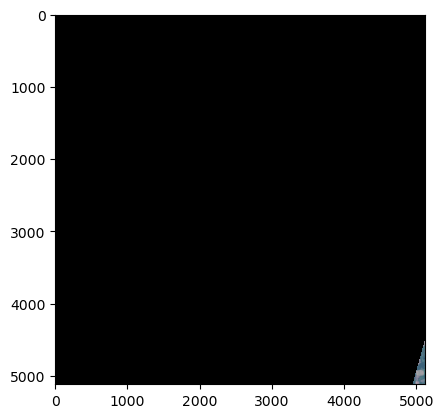

In [69]:
plt.imshow(np.clip(5*rgb,0 , 1))

In [89]:
with gdal.Open('/home/ccollado/phileo_phisat2/converted_tiff_files/denmark-1_12_phi2.tif') as src:
    rgb_DN = src_band(src, 'rgb')

(3, 5119, 5119)


In [90]:
rgb_DN = rgb_DN.astype(float)
rgb_DN[rgb_DN == 65535] = np.nan
rgb_DN = rgb_DN / 10000

In [91]:
rgb_DN

array([[[   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        ...,
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan]],

       [[   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        ...,
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan]],

       [[   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        ...,
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan]],

       ...,

       [[   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        ...,
        [0.0771, 0.0984, 0.1123],
        [0.0721, 0.0986, 0.1092],
        [0.0698, 0.0988, 0.108 ]],

       [[   nan,    nan,    nan],
        [   nan,    nan,    nan],
        [   nan,    nan,    nan],
        .

/home/ccollado/miniconda3/envs/phileo_env/lib/python3.9/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


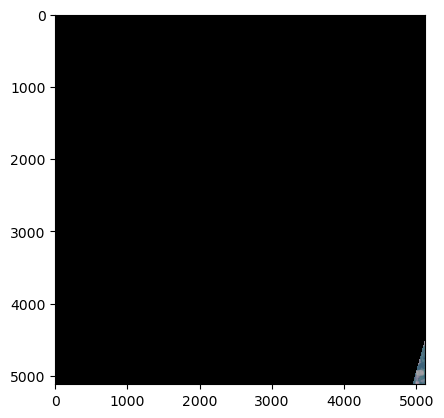

In [95]:
plt.imshow(np.clip(5*rgb_DN,0 , 1))

In [99]:
(np.isnan(rgb_DN) != np.isnan(rgb)).sum()

0

In [109]:
np.nanmin(rgb_DN * 10000)

332.0

In [106]:
np.max(np.abs(np.nan_to_num(rgb_DN - rgb))) * 10000

0.9999608993530029

# Get Radiance Values
- For radiance to DN, cannot simply multiply by 10000 (values reach over 200, and sometimes negative)
- Instead, to convert to uint, will find **min** and **max** values

In [1]:
import os
from osgeo import gdal

# Path to the folder containing TIFF files
folder_path = '/home/ccollado/phileo_phisat2/L1A/tiff_files'

# List to store names of corrupted TIFF files
corrupted_files = []

# Check each file in the directory
for filename in os.listdir(folder_path):
    if filename.endswith('.tif'):
        file_path = os.path.join(folder_path, filename)
        dataset = gdal.Open(file_path)
        if dataset is None:
            corrupted_files.append(filename)
        else:
            dataset = None  # Close the dataset

# Print out the list of corrupted files
print("Corrupted TIFF files:", corrupted_files)

if len(corrupted_files) > 0:
    raise Exception("Corrupted TIFF files found in the directory.")

Corrupted TIFF files: []


/home/ccollado/miniconda3/envs/phileo_env/lib/python3.9/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [53]:
import os
import glob
import numpy as np
from osgeo import gdal
from tqdm.contrib.concurrent import process_map  # Updated import

def process_file(file_path):
    """
    Process a single TIFF file to compute the min and max values for bands 1 to 8.

    Parameters:
        file_path (str): The path to the TIFF file.

    Returns:
        tuple: A tuple containing two numpy arrays:
            - band_mins: Minimum values for each band.
            - band_maxs: Maximum values for each band.
    """
    try:
        ds = gdal.Open(file_path)
        band_mins = []
        band_maxs = []
        for i in range(1, 9):  # Bands 1 to 8
            band = ds.GetRasterBand(i)
            # Compute statistics (min and max)
            stats = band.GetStatistics(True, True)
            band_mins.append(stats[0])  # Minimum value
            band_maxs.append(stats[1])  # Maximum value
        ds = None  # Close the dataset
        return np.array(band_mins), np.array(band_maxs)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None




directory = "/home/ccollado/phileo_phisat2/L1A/tiff_files"
file_list = glob.glob(os.path.join(directory, "*.tif"))

overall_mins = None
overall_maxs = None

# Use process_map from tqdm.contrib.concurrent to parallelize and show progress
results = process_map(
    process_file,
    file_list,
    max_workers=os.cpu_count(),  # Use the number of available CPU cores
    chunksize=1
)

# Aggregate the min and max values across all files
for result in results:
    if result is None:
        continue  # Skip files that couldn't be processed
    band_mins, band_maxs = result
    if overall_mins is None:
        overall_mins = band_mins
        overall_maxs = band_maxs
    else:
        overall_mins = np.minimum(overall_mins, band_mins)
        overall_maxs = np.maximum(overall_maxs, band_maxs)

# Output the results
for i in range(8):
    print(f"Band {i+1}: min = {overall_mins[i]}, max = {overall_maxs[i]}")


  0%|          | 0/1315 [00:00<?, ?it/s]

ERROR 1: nigeria_134.tif, band 1: Failed to compute statistics, no valid pixels found in sampling.
ERROR 1: nigeria_134.tif, band 2: Failed to compute statistics, no valid pixels found in sampling.
ERROR 1: nigeria_134.tif, band 3: Failed to compute statistics, no valid pixels found in sampling.
ERROR 1: nigeria_134.tif, band 4: Failed to compute statistics, no valid pixels found in sampling.
ERROR 1: nigeria_134.tif, band 5: Failed to compute statistics, no valid pixels found in sampling.
ERROR 1: nigeria_134.tif, band 6: Failed to compute statistics, no valid pixels found in sampling.
ERROR 1: nigeria_134.tif, band 7: Failed to compute statistics, no valid pixels found in sampling.
ERROR 1: nigeria_134.tif, band 8: Failed to compute statistics, no valid pixels found in sampling.
ERROR 1: south-america_1.tif, band 1: Failed to compute statistics, no valid pixels found in sampling.
ERROR 1: south-america_1.tif, band 2: Failed to compute statistics, no valid pixels found in sampling.
ER

Band 1: min = -1.7348840236663818, max = 992.0067138671875
Band 2: min = -2.07954478263855, max = 872.961181640625
Band 3: min = -2.114091396331787, max = 780.006591796875
Band 4: min = -0.5880829095840454, max = 826.3582153320312
Band 5: min = -1.281275987625122, max = 572.59423828125
Band 6: min = -3.626509189605713, max = 766.3739013671875
Band 7: min = -3.3695101737976074, max = 767.2091674804688
Band 8: min = -1.9370330572128296, max = 817.0570068359375


In [2]:
import os
import glob
import numpy as np
from osgeo import gdal
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

def process_tiff(file_path):
    """
    Process a single TIFF file to compute the min and max values for each of the first 8 bands.

    Parameters:
    - file_path: str, path to the TIFF file.

    Returns:
    - band_mins: list of min values for each band.
    - band_maxs: list of max values for each band.
    """
    try:
        ds = gdal.Open(file_path)
        if ds is None:
            return [np.nan]*8, [np.nan]*8

        num_bands = min(8, ds.RasterCount)  # Ensure we only process the first 8 bands
        band_mins = []
        band_maxs = []

        for i in range(1, num_bands + 1):
            band = ds.GetRasterBand(i).ReadAsArray()
            if band is None or np.all(np.isnan(band)):
                band_mins.append(np.nan)
                band_maxs.append(np.nan)
            else:
                band_mins.append(np.nanmin(band))
                band_maxs.append(np.nanmax(band))

        ds = None  # Close the dataset
        return band_mins, band_maxs

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return [np.nan]*8, [np.nan]*8

# Directory containing the TIFF files
tiff_dir = "/home/ccollado/phileo_phisat2/L1A/tiff_files"
tiff_files = glob.glob(os.path.join(tiff_dir, "*.tif"))

# Initialize overall min and max arrays for 8 bands
overall_mins = np.full(8, np.inf)
overall_maxs = np.full(8, -np.inf)

# Number of processes to use (you can adjust this)
num_processes = cpu_count()

with Pool(processes=num_processes) as pool:
    # Use imap_unordered for efficient memory usage with tqdm
    results = pool.imap_unordered(process_tiff, tiff_files)
    for band_mins, band_maxs in tqdm(results, total=len(tiff_files), desc="Processing TIFF files"):
        # Update overall min and max for each band
        for idx in range(8):
            if not np.isnan(band_mins[idx]):
                overall_mins[idx] = min(overall_mins[idx], band_mins[idx])
            if not np.isnan(band_maxs[idx]):
                overall_maxs[idx] = max(overall_maxs[idx], band_maxs[idx])

# Print the results
for idx in range(8):
    print(f"Band {idx+1}: Min = {overall_mins[idx]}, Max = {overall_maxs[idx]}")

Processing TIFF files: 100%|██████████| 1315/1315 [26:02<00:00,  1.19s/it] 


Band 1: Min = -1.8809680938720703, Max = 1128.3280029296875
Band 2: Min = -2.3193440437316895, Max = 934.764404296875
Band 3: Min = -2.3585681915283203, Max = 879.5845336914062
Band 4: Min = -0.7101852893829346, Max = 863.93017578125
Band 5: Min = -1.511198878288269, Max = 639.3428955078125
Band 6: Min = -3.698456287384033, Max = 909.0509643554688
Band 7: Min = -3.8417840003967285, Max = 892.326416015625
Band 8: Min = -2.4129557609558105, Max = 977.6026611328125


In [15]:
import sys
sys.path.append('/home/ccollado/1_simulate_data/phisat_2')
from utils import src_band


tiff_dir = "/home/ccollado/phileo_phisat2/L1A/tiff_files"
tif = os.listdir(tiff_dir)[0]
tif_path = os.path.join(tiff_dir, tif)
with gdal.Open(tif_path) as ds:
    band_names = src_band(ds, 'bands_names')

In [24]:
dict_maxmin = {}
for i, (band, value) in enumerate(band_names.items()):
    dict_maxmin[band] = (overall_mins[i], overall_maxs[i])
    if i == 7:
        break

In [25]:
dict_maxmin

{'PHISAT2-B02': (-1.8809680938720703, 1128.3280029296875),
 'PHISAT2-B03': (-2.3193440437316895, 934.764404296875),
 'PHISAT2-B04': (-2.3585681915283203, 879.5845336914062),
 'PHISAT2-PAN': (-0.7101852893829346, 863.93017578125),
 'PHISAT2-B08': (-1.511198878288269, 639.3428955078125),
 'PHISAT2-B05': (-3.698456287384033, 909.0509643554688),
 'PHISAT2-B06': (-3.8417840003967285, 892.326416015625),
 'PHISAT2-B07': (-2.4129557609558105, 977.6026611328125)}

In [27]:
arr = np.load('/home/ccollado/phileo_phisat2/np_patches_224/denmark-1_1_train_s2.npy')
arr.shape

(254, 224, 224, 8)

In [28]:
arr = np.load('/home/ccollado/phileo_phisat2/np_patches_128/denmark-1_1_train_s2.npy')
arr.shape

(554, 128, 128, 8)

In [34]:
with gdal.Open('/home/ccollado/phileo_phisat2/tiff_files/east-africa_6_phi2.tif') as src:
    metadata = src.GetMetadata()
    band_data = src_band(src, 'rgb')

(3, 5119, 5119)


# Check tif High Values

In [36]:
file = 'north-america_36.tif'
folder_path = '/home/ccollado/phileo_phisat2/L1A/tiff_files'

import os
from osgeo import gdal

# Open the TIFF file
file_path = os.path.join(folder_path, file)
dataset = gdal.Open(file_path)
data = dataset.ReadAsArray()


In [41]:
bands = data[:8]
bands.max()

986.7125